# 5-step Forecasting Task

1. Problem Definition
2. Gathering Information
3. Preliminary Exploratory Analysis
4. Choosing and Fitting Models
5. Using and Evaluating a Forecasting Model

## Problem Definition

The problem is to predict the number of monthly armed robberies in Boston, USA.
Data: number of monthly armed robberies in Boston from January 1966 to October 1975

In [46]:
import pandas as pd
df = pd.read_csv("data/Robberies.csv")

In [47]:
df.shape

(118, 2)

In [48]:
df.head()

,Months,Robberies
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43


## Validation Dataset

In [49]:
split_point = len(df) - 12

dataset, validation = df[0:split_point], df[split_point:]

## Model Evaluation


In [84]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def evaluate_forecast(actual_values, predicted):
    mse = mean_squared_error(actual_values, predicted)
    rmse = sqrt(mse)

    return mse, rmse


## Data Analysis

1. Summary Statistics
2. Line Plots
3. Density Plots
4. Box and Whiskers Plot

In [16]:
dataset.describe()

,Robberies
count,106.000000
mean,173.103774
std,112.231133
min,29.000000
25%,74.750000
50%,144.500000
75%,271.750000
max,487.000000


In [50]:
dataset.columns

Index(['Months', 'Robberies'], dtype='object')

/var/folders/72/x6_kg98117nd5xkqbx_bl3dc0000gn/T/ipykernel_42334/3651481684.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['Months'] = pd.to_datetime(dataset['Months'])


<Axes: xlabel='Months'>

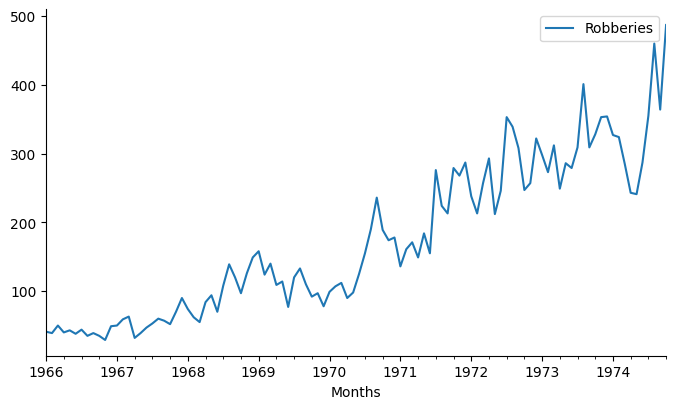

In [51]:
dataset['Months'] = pd.to_datetime(dataset['Months'])
dataset.set_index('Months', inplace=True)
dataset.plot()

- There is an increasing trend of robberies over time
- There do not appear to be any obvious outliers
- There are fluctuations from year to year
- Non-stationary

In [52]:
from utils import *
fit = sm.tsa.STL(dataset.Robberies).fit()

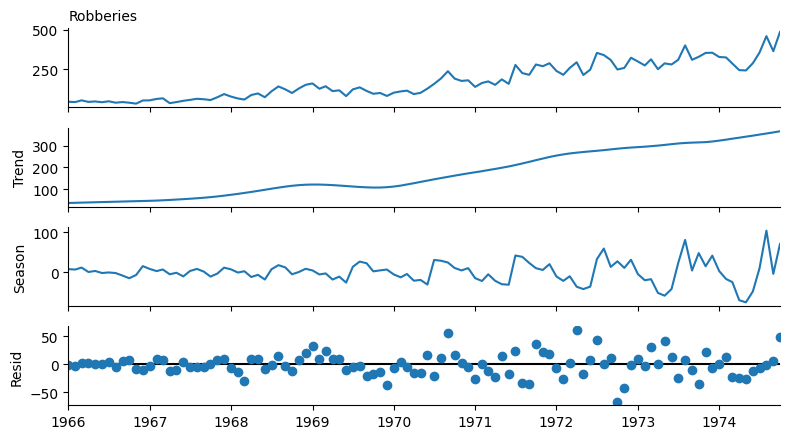

In [53]:
fit.plot();

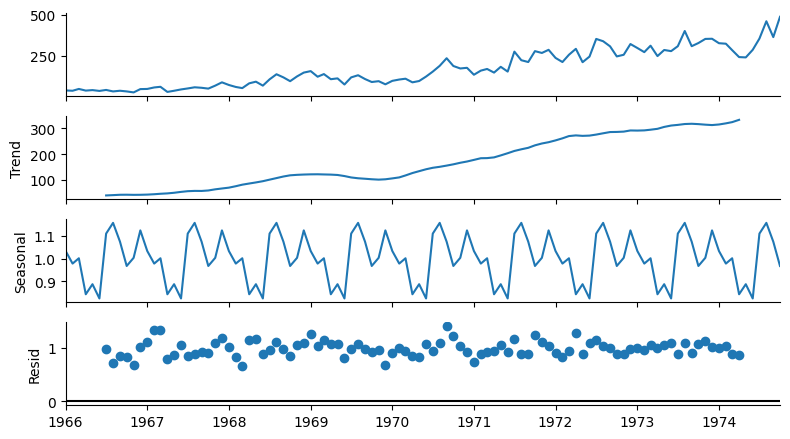

In [54]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(dataset, model='multiplicative').plot();

## Choosing and Fitting models

1. Try Mean, Naive, Seasonal Naive and Drift to predict.

In [55]:
dataset.shape

(106, 1)

In [56]:
dataset.dtypes

Robberies    int64
dtype: object

In [57]:
dataset

,Robberies
Months,
1966-01-01,41
1966-02-01,39
1966-03-01,50
1966-04-01,40
1966-05-01,43
...,...
1974-06-01,287
1974-07-01,355
1974-08-01,460


In [58]:
class SimpleTSModel:
    """Simple TS model base class."""
    def __init__(self, y):
        """Determine y data and sampling frequency."""
        if not hasattr(y, 'index'):
            y = pd.Series(y)
        if hasattr(y.index, 'inferred_freq'):
            self.y = y.asfreq(y.index.inferred_freq)
            self.freq = self.y.index.freq
        else:
            self.y = y.copy()
            self.freq = None

    def fit(self):
        """Nothing to do here, but in other libraries this is a method that does things."""
        return self

    def forecast(self, dt=None, end=None, periods=None):
        """Make a forward-looking prediction."""
        assert sum([dt is None, end is None, periods is None]) == 2
        tmax = self.y.index.max()
        if dt is not None:
            end = tmax + (pd.to_timedelta(dt) if self.freq else dt)
        elif end is not None:
            end = pd.to_datetime(end) if self.freq else end
        elif periods is not None:
            end = tmax + periods * (self.freq or 1)
        return self.predict(tmax + 1 * (self.freq or 1), end)

    def _normalize_times(self, start, end):
        """Do some tedious datetime manipulation."""
        Y = self.y
        t0 = Y.index.min()
        if start is None:
            start = t0
        if end is None:
            end = Y.index.max()
        if self.freq is not None:
            start = pd.to_datetime(start)
            end = pd.to_datetime(end)
        if self.freq:
            index = pd.date_range(t0, end, freq=self.freq)
        else:
            index = np.arange(t0, end+1)
        return start, end, index

class TSMean(SimpleTSModel):
    """The future will look like the average of the past."""
    def predict(self, start=None, end=None):
        # value is always the mean
        Y = self.y
        start, end, index = self._normalize_times(start, end)
        m = Y.mean()
        out = pd.Series(m, index=index)
        out = out.loc[start:].copy()
        return out

class TSNaive(SimpleTSModel):
    """Tomorrow will look like today."""
    def predict(self, start=None, end=None):
        # tomorrow probably same as today
        Y = self.y
        start, end, index = self._normalize_times(start, end)
        out = pd.Series(np.nan, index=index)
        out.loc[:Y.index.max()] = Y
        out = out.shift(1)
        out.loc[Y.index.max():] = Y.iloc[-1]
        out = out.loc[start:].copy()
        return out.copy()

class TSNaiveSeasonal(SimpleTSModel):
    """Next year will fluctuate the same way as this year."""
    def __init__(self, y, lag):
        super(TSNaiveSeasonal, self).__init__(y)
        self.lag = lag
        assert self.y.index.min() + lag * (self.freq or 1) < self.y.index.max(), \
            'lag must be less than input timeseries'

    def predict(self, start=None, end=None):
        # tomorrow probably same as this time last year/month/whatever
        Y, lag = self.y, self.lag
        start, end, index = self._normalize_times(start, end)
        out = pd.Series(np.nan, index=index)
        out.loc[:Y.index.max()] = Y
        out = out.shift(lag)
        i = 0
        while np.isnan(out.iloc[-1]):
            mask = out.isna()
            out[mask] = out.shift(lag)[mask]
            i += 1
        out = out.loc[start:].copy()
        return out.copy()

class TSDrift(SimpleTSModel):
    """Draw a line from t=0 thru today, and extrapolate to tomorrow."""
    def predict(self, start=None, end=None):
        # value extrapolated based on slope wrt first observation
        # TODO: might be slightly wrong
        # doesn't *quite* agree with R's RW(Y~drift()) ?
        Y = self.y
        Y0 = Y.values[0]
        YT = Y.shift(-1)
        start, end, index = self._normalize_times(start, end)
        YT = pd.Series(np.nan, index=index)
        YT.loc[Y.index.min():Y.index.max()] = Y
        YT = YT.shift(1)
        YT.iloc[0] = Y.iloc[0]
        h = pd.Series(1, index=index)
        extrap_mask = YT.isna()
        h.loc[YT.isna()] = np.arange(1, extrap_mask.sum()+1)
        YT.loc[extrap_mask] = Y.iloc[-1]
        x = np.maximum(1, np.arange(len(YT)) - 1)
        out = YT + h * ((YT - Y0) / x)
        out.iloc[0] = np.nan
        out = out.loc[start:].copy()
        return out.copy()

In [59]:
validation['Months'] = pd.to_datetime(validation['Months'])
validation.set_index('Months', inplace=True)


/var/folders/72/x6_kg98117nd5xkqbx_bl3dc0000gn/T/ipykernel_42334/3733738559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Months'] = pd.to_datetime(validation['Months'])


In [73]:
Ytrain = dataset.Robberies
nsamples = len(Ytrain)
m = TSMean(Ytrain)
n = TSNaive(Ytrain).fit()
s = TSNaiveSeasonal(Ytrain, 12)
dr = TSDrift(Ytrain)

In [74]:
df['Months'] = pd.to_datetime(df['Months'])
df.set_index('Months', inplace=True)

KeyError: 'Months'

In [75]:
dr.forecast(end='1975-10-01')

1974-11-01    491.247619
1974-12-01    491.207547
1975-01-01    495.336449
1975-02-01    499.388889
1975-03-01    503.366972
1975-04-01    507.272727
1975-05-01    511.108108
1975-06-01    514.875000
1975-07-01    518.575221
1975-08-01    522.210526
1975-09-01    525.782609
1975-10-01    529.293103
Freq: MS, dtype: float64

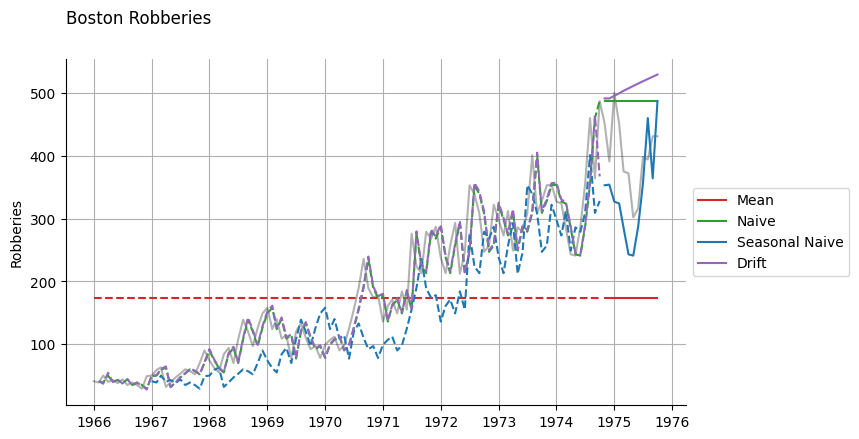

In [76]:
fig, ax = plt.subplots()
ax.plot(df, color='k', alpha=0.3)
c = 'C3 C2 C0 C4'.split()
ax.plot(m.predict(),  ls='--', color=c[0])
ax.plot(n.predict(),  ls='--', color=c[1])
ax.plot(s.predict(),  ls='--', color=c[2])
ax.plot(dr.predict(), ls='--', color=c[3])
ax.plot(m.forecast(end='1975-10-01'),  color=c[0], label='Mean')
ax.plot(n.forecast(end='1975-10-01'),  color=c[1], label='Naive')
ax.plot(s.forecast(end='1975-10-01'),  color=c[2], label='Seasonal Naive')
ax.plot(dr.forecast(end='1975-10-01'), color=c[3], label='Drift')
ax.set(ylabel='Robberies')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Boston Robberies')
ax.grid()

## Using and Evaluating a Forecasting Model

In [77]:
results = dataset.assign(
    mean=m.predict(),
    naive=n.predict(),
    naive_seasonal=s.predict(),
    drift=dr.predict(),
    resid_mean=m.predict() - Ytrain,
    resid_naive=n.predict() - Ytrain,
    resid_naive_seasonal=s.predict() - Ytrain,
    resid_drift=dr.predict() - Ytrain,
)
results.tail(20)


,Robberies,mean,naive,naive_seasonal,drift,resid_mean,resid_naive,resid_naive_seasonal,resid_drift
Months,,,,,,,,,
1973-03-01,312,173.103774,273.0,257.0,275.729412,-138.896226,-39.0,-55.0,-36.270588
1973-04-01,249,173.103774,312.0,293.0,315.151163,-75.896226,63.0,44.0,66.151163
1973-05-01,286,173.103774,249.0,212.0,251.390805,-112.896226,-37.0,-74.0,-34.609195
1973-06-01,279,173.103774,286.0,246.0,288.784091,-105.896226,7.0,-33.0,9.784091
1973-07-01,309,173.103774,279.0,353.0,281.674157,-135.896226,-30.0,44.0,-27.325843
1973-08-01,401,173.103774,309.0,339.0,311.977778,-227.896226,-92.0,-62.0,-89.022222
1973-09-01,309,173.103774,401.0,308.0,404.956044,-135.896226,92.0,-1.0,95.956044
1973-10-01,328,173.103774,309.0,247.0,311.913043,-154.896226,-19.0,-81.0,-16.086957
1973-11-01,353,173.103774,328.0,257.0,331.086022,-179.896226,-25.0,-96.0,-21.913978


In [80]:
results

,Robberies,mean,naive,naive_seasonal,drift,resid_mean,resid_naive,resid_naive_seasonal,resid_drift
Months,,,,,,,,,
1966-01-01,41,173.103774,NaN,NaN,NaN,132.103774,NaN,NaN,NaN
1966-02-01,39,173.103774,41.0,NaN,41.000000,134.103774,2.0,NaN,2.000000
1966-03-01,50,173.103774,39.0,NaN,37.000000,123.103774,-11.0,NaN,-13.000000
1966-04-01,40,173.103774,50.0,NaN,54.500000,133.103774,10.0,NaN,14.500000
1966-05-01,43,173.103774,40.0,NaN,39.666667,130.103774,-3.0,NaN,-3.333333
...,...,...,...,...,...,...,...,...,...
1974-06-01,287,173.103774,241.0,279.0,243.000000,-113.896226,-46.0,-8.0,-44.000000
1974-07-01,355,173.103774,287.0,309.0,289.435644,-181.896226,-68.0,-46.0,-65.564356
1974-08-01,460,173.103774,355.0,401.0,358.078431,-286.896226,-105.0,-59.0,-101.921569


In [79]:
results.isna().sum()

Robberies                0
mean                     0
naive                    1
naive_seasonal          12
drift                    1
resid_mean               0
resid_naive              1
resid_naive_seasonal    12
resid_drift              1
dtype: int64

In [81]:
def plot_tsresiduals(Y, y, acf_lags=np.r_[1:26]):
    """Plot timeseries residuals for ground truth Y and estimate y."""
    fig = plt.figure()
    gs = plt.GridSpec(3, 2, figure=fig)
    ts_ax = fig.add_subplot(gs[0, :])
    axs = np.array([ts_ax] + [fig.add_subplot(gs[i, j]) for j in (0, 1) for i in (1, 2)])
    ax, rax, hax, acfax, pacfax = axs
    mask = ~(np.isnan(Y) | np.isnan(y))
    Y, y = Y[mask], y[mask]
    dy = Y - y
    ax.plot(Y, color='k')
    ax.plot(y)
    ax.set(title='Time Series')
    lim = 1.1 * max(-dy.min(), dy.max())
    lim = -lim, lim
    rax.plot(dy)
    rax.set(ylim=lim, title='Residuals')
    sns.histplot(dy, bins=np.linspace(lim[0], lim[1], 22),
             kde=True, stat='density', ax=hax)
    hax.set(title='Residual Distribution')
    sm.graphics.tsa.plot_acf(dy, lags=acf_lags, ax=acfax)
    acfax.set_ylim(-0.5, 0.5)
    sm.graphics.tsa.plot_pacf(dy, lags=acf_lags, ax=pacfax)
    pacfax.set_ylim(-0.5, 0.5)
    for a in axs.ravel():
        a.grid()
    plt.tight_layout()
    return fig, axs


/Users/gabrielasoares/.local/share/virtualenvs/cda-m6uw-1w4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


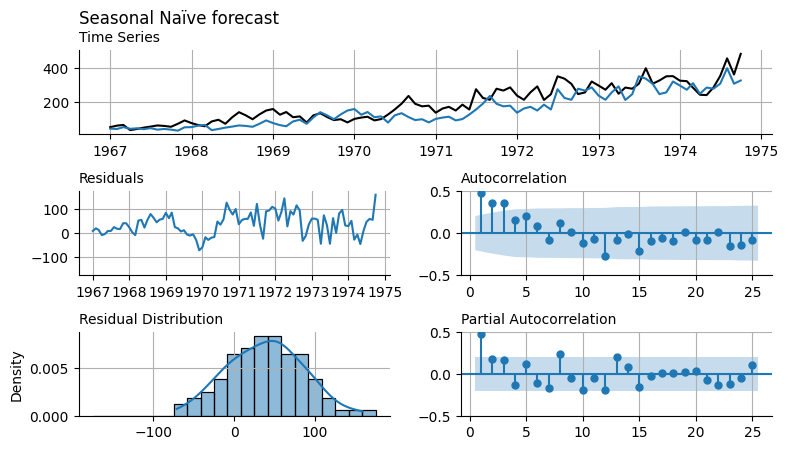

In [83]:
plot_tsresiduals(Ytrain, results.naive_seasonal)
suptitle('Seasonal Naïve forecast')
plt.subplots_adjust(top=.9)

/Users/gabrielasoares/.local/share/virtualenvs/cda-m6uw-1w4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


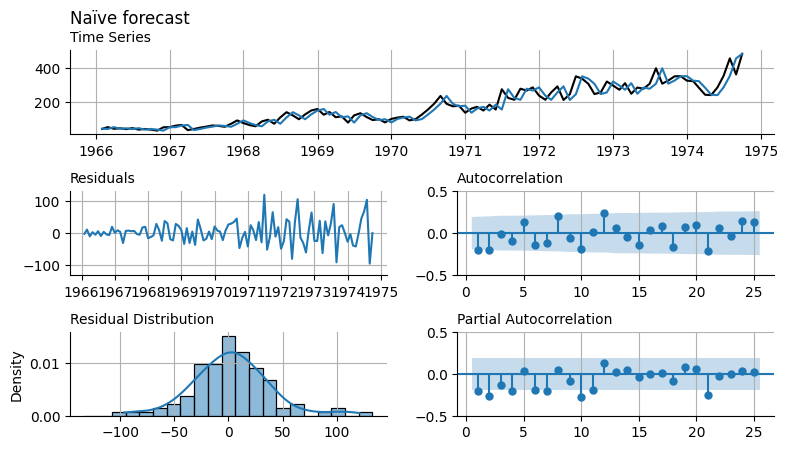

In [85]:
plot_tsresiduals(Ytrain, results.naive)
suptitle('Naïve forecast')
plt.subplots_adjust(top=.9)

In [91]:
evaluate_forecast(validation, m.forecast(end='1975-10-01'))

(54924.922718642476, 234.36066802823908)

In [92]:
evaluate_forecast(validation, n.forecast(end='1975-10-01'))

(10331.916666666666, 101.64603615816343)

In [93]:
evaluate_forecast(validation, s.forecast(end='1975-10-01'))

(8363.416666666666, 91.45171768024188)

In [94]:
evaluate_forecast(validation, dr.forecast(end='1975-10-01'))

(15135.084865849545, 123.02473274041097)

In [100]:
stl = sm.tsa.STL(dataset.Robberies).fit()

In [101]:
s_stl = TSNaiveSeasonal(stl.seasonal, 12)

In [102]:
dr_stl = TSDrift(dataset.Robberies - stl.seasonal)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


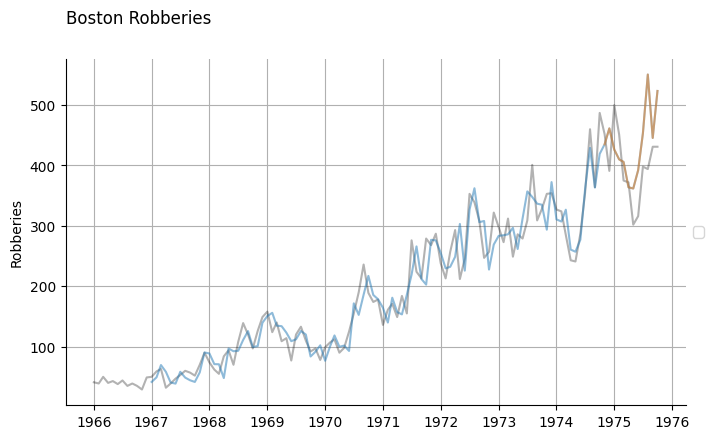

In [104]:
fig, ax = plt.subplots()
ax.plot(df, color='k', alpha=0.3)
c = 'C3 C2 C0 C4'.split()
end = '1975-10-01'
ax.plot(s_stl.predict(end=end) + dr_stl.predict(end=end), alpha=0.5)
ax.plot(s_stl.forecast(end=end) + dr_stl.forecast(end=end), alpha=0.5)
ax.set(ylabel='Robberies')
ax.legend(loc='center left', bbox_to_anchor=[1, .5])
suptitle('Boston Robberies')
ax.grid()

/Users/gabrielasoares/.local/share/virtualenvs/cda-m6uw-1w4/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


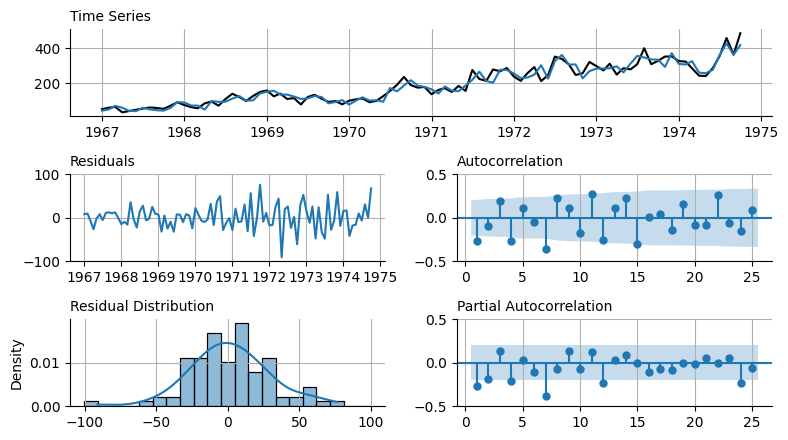

In [105]:
plot_tsresiduals(dataset.Robberies, s_stl.predict() + dr_stl.predict());


In [106]:
evaluate_forecast(validation, s_stl.forecast(end=end) + dr_stl.forecast(end=end))

(4920.1604028950815, 70.14385506154535)